In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn import metrics

import warnings
warnings.filterwarnings('ignore')

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Read the data from the bitcoin dataset provided by keggle

In [13]:
df = pd.read_csv('/kaggle/input/bitcoin-historical-data/btcusd_1-min_data.csv')
#remove null data from the table
df2 = df.dropna()
#make the epoh in sec timestamp more readable
# Converting the 'Timestamp' column to a datetime object
df2['Datetime'] = pd.to_datetime(btc_data['Timestamp'], unit='s')

# Extracting components into separate columns
df2['Year'] = df2['Datetime'].dt.year
df2['Month'] = df2['Datetime'].dt.month
df2['Day'] = df2['Datetime'].dt.day
df2['Hour'] = df2['Datetime'].dt.hour
btc_data['Minutes'] = df2['Datetime'].dt.minute
df2['Seconds'] = df2['Datetime'].dt.second

# df2.head()

# Get the latest date in the dataset
latest_date = df2['Datetime'].max()

# Calculate the date 8 years ago
years_ago = latest_date - pd.DateOffset(years=8)

# Filter the data to include only the last 8 years
btc_data = df2[df2['Datetime'] >= years_ago]

# Dropping the temporary 'Datetime' column (optional)
btc_data.drop(columns=['Datetime'], inplace=True)

# Display the first few rows to verify
print(btc_data.head())


            Timestamp    Open    High     Low   Close     Volume  Year  Month  \
2618459  1.482538e+09  895.10  895.10  893.96  893.96  28.359477  2016     12   
2618460  1.482538e+09  893.64  894.69  891.72  894.15  40.285579  2016     12   
2618461  1.482538e+09  893.97  893.97  892.00  892.00  36.975490  2016     12   
2618462  1.482538e+09  892.09  892.09  892.00  892.00  30.000000  2016     12   
2618463  1.482538e+09  892.01  892.01  891.00  891.00  20.000000  2016     12   

         Day  Hour  Seconds  
2618459   24     0        0  
2618460   24     0        0  
2618461   24     0        0  
2618462   24     0        0  
2618463   24     0        0  


Exploratory Data Analysis:
analyze how prices of the cryptocurrency have moved over the period of time and how the end of the quarters affects the prices of the currency.

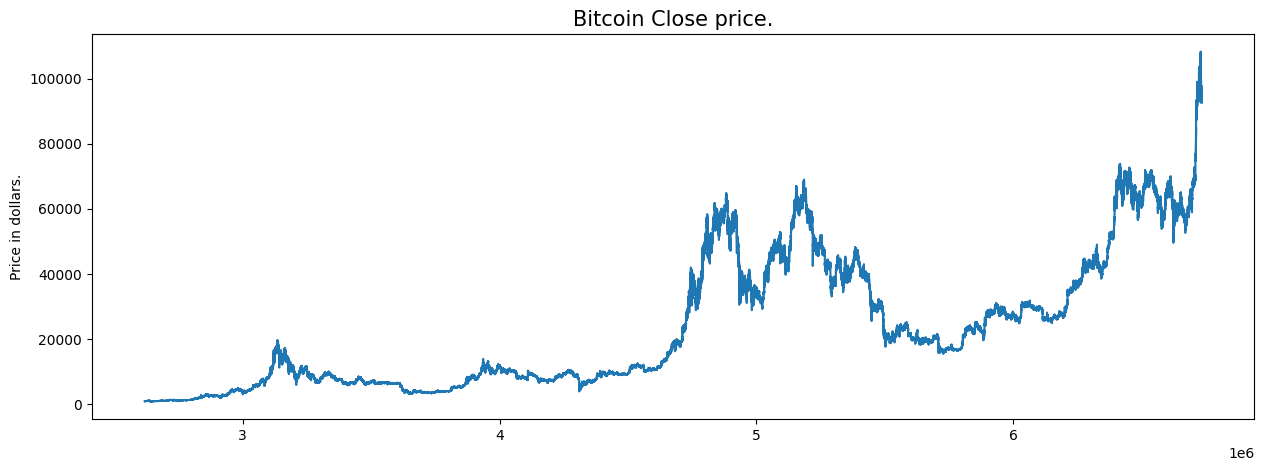

In [14]:
plt.figure(figsize=(15, 5))
plt.plot(btc_data['Close'])
plt.title('Bitcoin Close price.', fontsize=15)
plt.ylabel('Price in dollars.')
plt.show()

In [15]:
# btc_data[btc_data['Close'] == btc_data['Adj Close']].shape, btc_data.shape
# make sure no null values is present in the data
btc_data.isnull().sum()

Timestamp    0
Open         0
High         0
Low          0
Close        0
Volume       0
Year         0
Month        0
Day          0
Hour         0
Seconds      0
dtype: int64

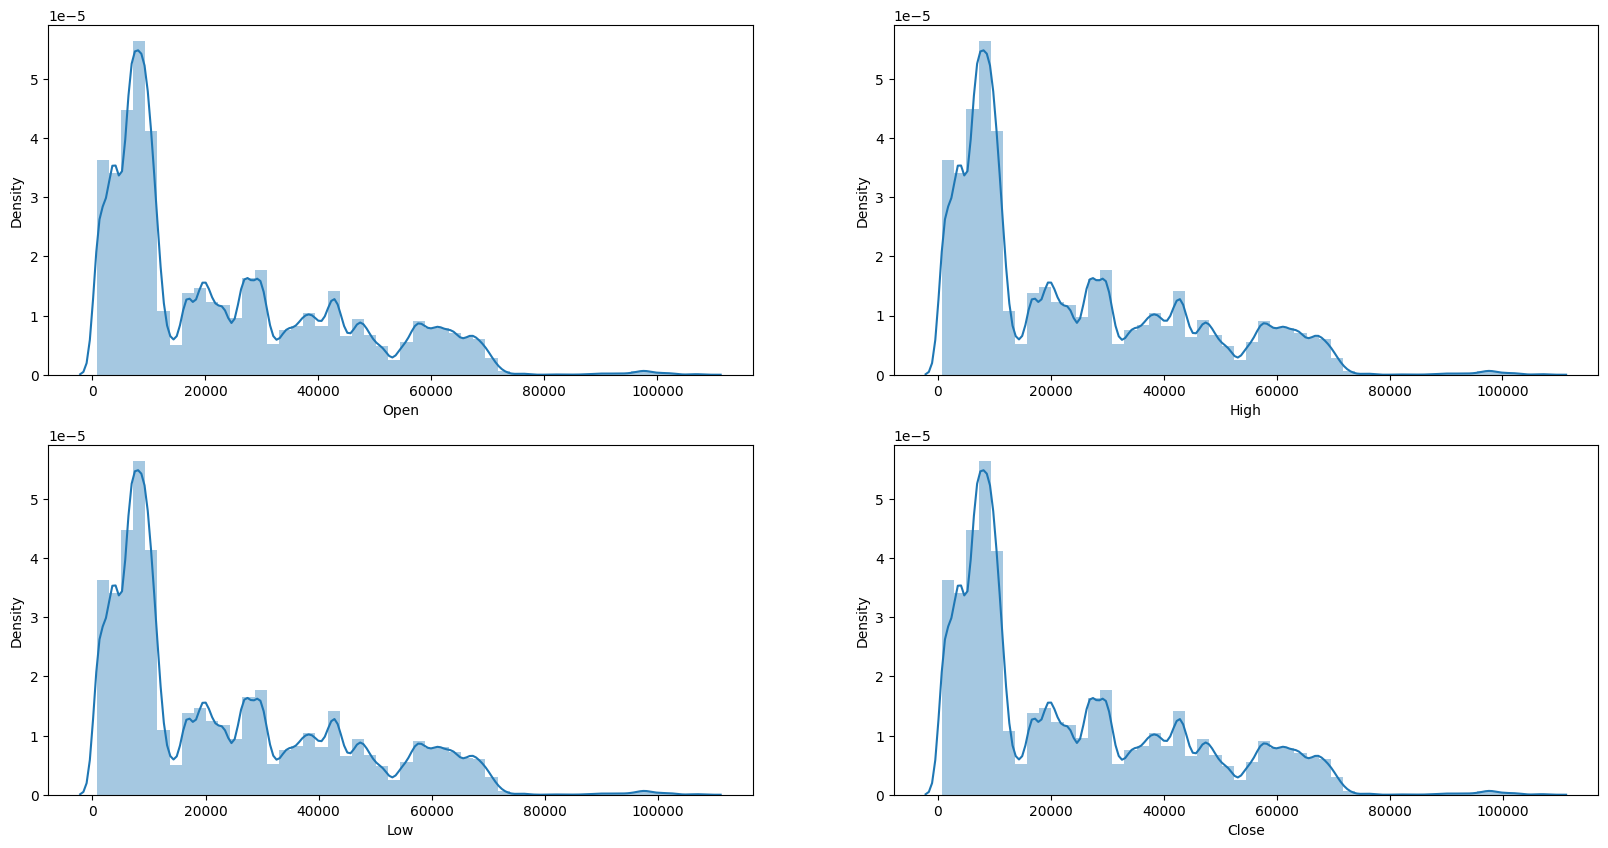

In [16]:
features = ['Open', 'High', 'Low', 'Close']
plt.subplots(figsize=(20,10))

for i, col in enumerate(features):
  plt.subplot(2,2,i+1)
  sb.distplot(btc_data[col])
plt.show()

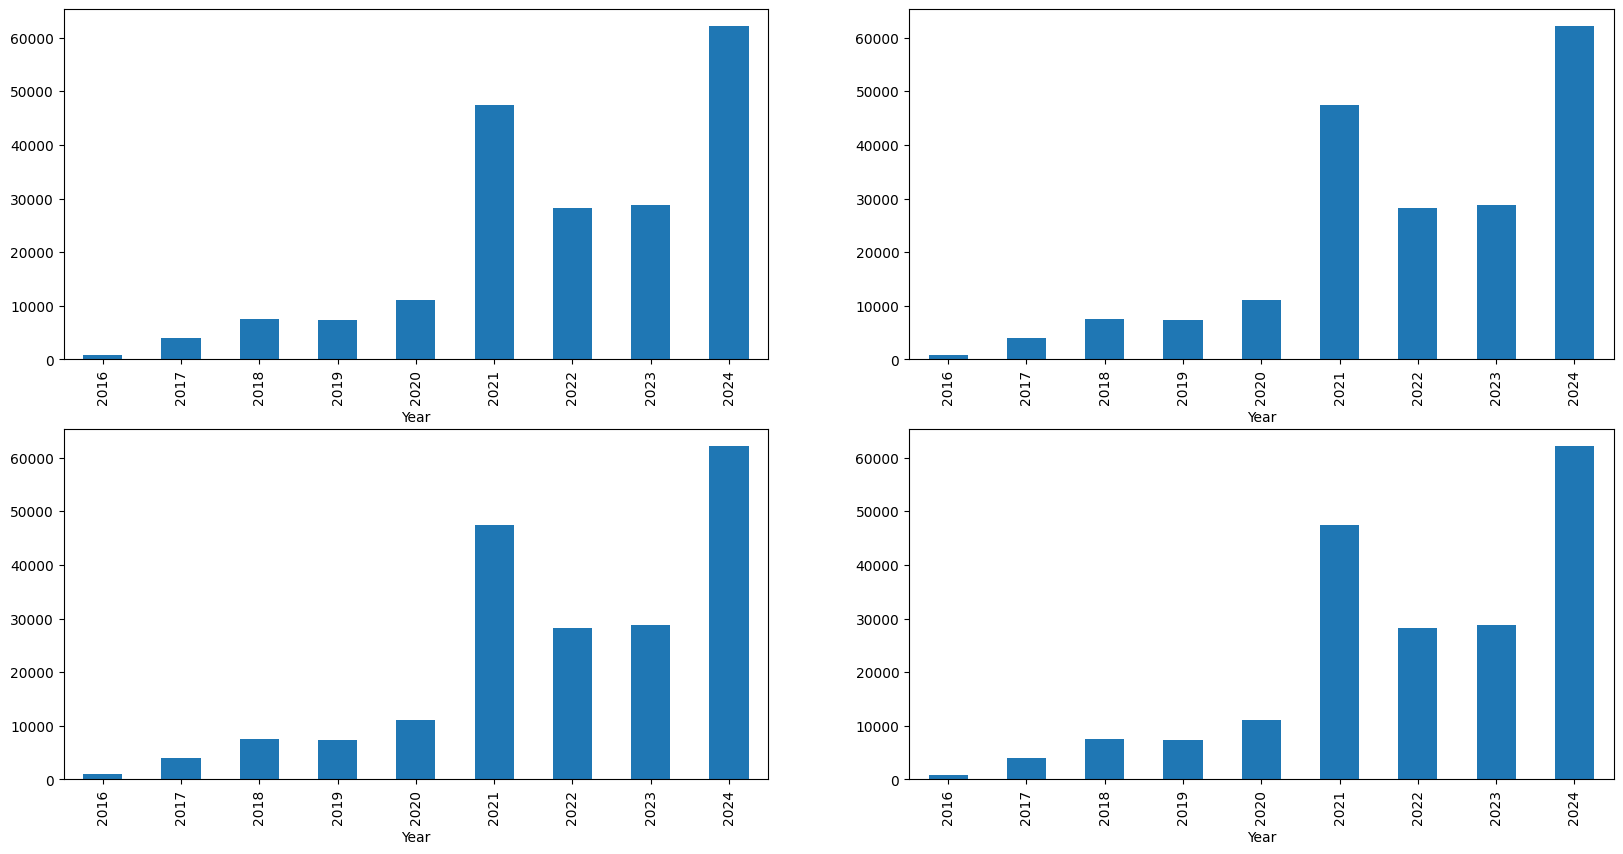

In [17]:
data_grouped = btc_data.groupby('Year').mean()
plt.subplots(figsize=(20,10))
for i, col in enumerate(['Open', 'High', 'Low', 'Close']):
  plt.subplot(2,2,i+1)
  data_grouped[col].plot.bar()
plt.show()

In [18]:

btc_data['is_quarter_end'] = np.where(btc_data['Month']%3==0,1,0)
btc_data.tail()

,Timestamp,Open,High,Low,Close,Volume,Year,Month,Day,Hour,Seconds,is_quarter_end
6733275,1.734998e+09,94708.0,94724.0,94708.0,94724.0,0.005236,2024,12,23,23,0,1
6733276,1.734998e+09,94724.0,94724.0,94724.0,94724.0,0.000000,2024,12,23,23,0,1
6733277,1.734998e+09,94724.0,94724.0,94724.0,94724.0,0.000000,2024,12,23,23,0,1
6733278,1.734998e+09,94720.0,94750.0,94720.0,94750.0,2.000000,2024,12,23,23,0,1
6733279,1.734998e+09,94750.0,94750.0,94691.0,94691.0,0.208403,2024,12,24,0,0,1


In [19]:
btc_data['Open-Close']  = btc_data['Open'] - btc_data['Close']
btc_data['Low-High']  = btc_data['Low'] - btc_data['High']
btc_data['Target'] = np.where(btc_data['Close'].shift(-1) > btc_data['Close'], 1, 0)

btc_data.tail()

,Timestamp,Open,High,Low,Close,Volume,Year,Month,Day,Hour,Seconds,is_quarter_end,Open-Close,Low-High,Target
6733275,1.734998e+09,94708.0,94724.0,94708.0,94724.0,0.005236,2024,12,23,23,0,1,-16.0,-16.0,0
6733276,1.734998e+09,94724.0,94724.0,94724.0,94724.0,0.000000,2024,12,23,23,0,1,0.0,0.0,0
6733277,1.734998e+09,94724.0,94724.0,94724.0,94724.0,0.000000,2024,12,23,23,0,1,0.0,0.0,1
6733278,1.734998e+09,94720.0,94750.0,94720.0,94750.0,2.000000,2024,12,23,23,0,1,-30.0,-30.0,0
6733279,1.734998e+09,94750.0,94750.0,94691.0,94691.0,0.208403,2024,12,24,0,0,1,59.0,-59.0,0


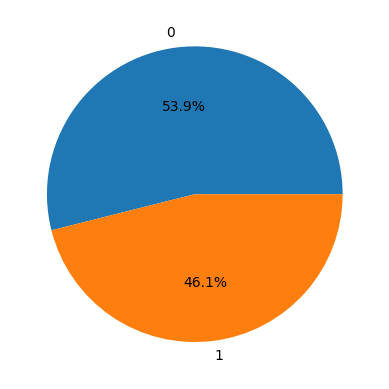

In [20]:
plt.pie(btc_data['Target'].value_counts().values, 
        labels=[0, 1], autopct='%1.1f%%')
plt.show()

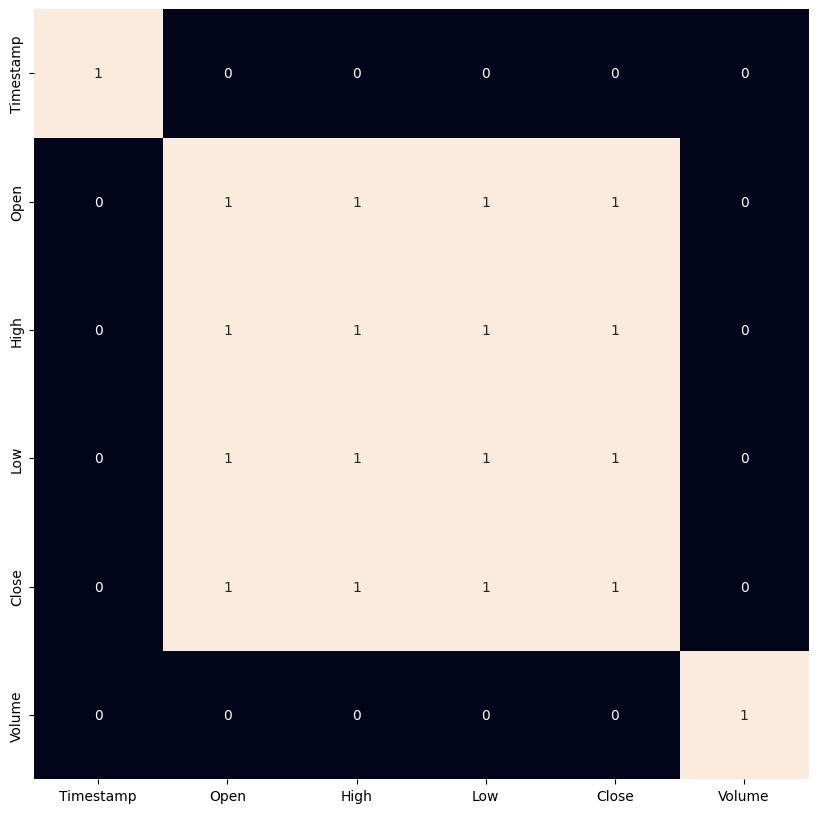

In [21]:
plt.figure(figsize=(10, 10))

# As our concern is with the highly
# correlated features only so, we will visualize
# our heatmap as per that criteria only.
sb.heatmap(df.corr() > 0.9, annot=True, cbar=False)
plt.show()

In [22]:
features_z = btc_data[['Open-Close', 'Low-High', 'is_quarter_end']]
target_z = btc_data['Target']

scaler = StandardScaler()
features_z = scaler.fit_transform(features_z)
#We do not use train test split, rather use the first 70% data to train and last 30% to test
X_train, X_valid, Y_train, Y_valid = X_train, X_valid, Y_train, Y_valid = features_z[:len(features_z)//7],features_z[len(features_z)//7:],target_z[:len(features_z)//7],target_z[len(features_z)//7:]

In [ ]:
models = [LogisticRegression(), SVC(kernel='poly', probability=True), XGBClassifier()]

for i in range(3):
  models[i].fit(X_train, Y_train)

  print(f'{models[i]} : ')
  print('Training Accuracy : ', metrics.roc_auc_score(Y_train, models[i].predict_proba(X_train)[:,1]))
  print('Validation Accuracy : ', metrics.roc_auc_score(Y_valid, models[i].predict_proba(X_valid)[:,1]))
  print()

LogisticRegression() : 
Training Accuracy :  0.5826699520513237
Validation Accuracy :  0.5502693857234895



In [2]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_estimator(models[0], X_valid, Y_valid)
plt.show()


NameError: name 'btc_data' is not defined